In [26]:
%%shell
jupyter nbconvert --to=html '/content/code_23386320v0_1 (1).ipynb'

[NbConvertApp] Converting notebook /content/code_23386320v0_1 (1).ipynb to html
[NbConvertApp] Writing 581845 bytes to /content/code_23386320v0_1 (1).html


# Assignment 2 for FIT5212, TP5 2021

**Student Name:**  Sadia Karim

**Student ID:**    23386320

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> # Part 1

In [ ]:
!pip install 'lightfm' 'implicit' 'pytorch_lightning'

In [28]:
import random
import torch
SEED = 99
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [29]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

import implicit 
from implicit import evaluation

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as toptim
import tensorflow as tf
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

import warnings; warnings.simplefilter('ignore')

In [30]:
# Load training data
train = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/train_data.csv")

# Load validation data
valid = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/validation_data.csv")

# Load test data
test = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/test_data.csv")

# Load item information
item_fea = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/item_fea.csv")

# Load user information
user_fea = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/user_fea.csv")

In [31]:
n_ratings = len(train)
n_items = train['item_id'].nunique()
n_users = train['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique items: {n_items}")
print(f"Number of unique users: {n_users}")
avg_num_ratings = round(n_ratings/n_users, 2)
print(f"Average number of ratings per user: {avg_num_ratings}")
print(f"Average number of ratings per item: {round(n_ratings/n_items, 2)}")
print('Sparsity: {:4.3f}%'.format(float(train.shape[0]) / float(n_users*n_items) * 100))

Number of ratings: 28449
Number of unique items: 2174
Number of unique users: 2239
Average number of ratings per user: 12.71
Average number of ratings per item: 13.09
Sparsity: 0.584%


In [32]:
# Remove duplicated rows
print('Valid Duplicated rows: ' + str(valid.duplicated().sum()))
valid = valid.drop_duplicates()

print('Test Duplicated rows: ' + str(test.duplicated().sum()))
test = test.drop_duplicates()

Valid Duplicated rows: 4925
Test Duplicated rows: 5049


In [33]:
# get user and item feature matrices, remove first column indicating the item number
user_fea = user_fea.iloc[: , 1:]
item_fea = item_fea.iloc[: , 1:]

In [34]:
# create sparse user and item matrices
sparse_user_fea = sparse.csr_matrix((user_fea))
sparse_item_fea = sparse.csr_matrix((item_fea))

In [35]:
# create identity matrices for users and items for use with LightFM
user_I = np.identity(n_users)
item_I = np.identity(n_items)

In [36]:
# concatenate feature and identity matrices for use in LightFM
user_I_fea = sparse.csr_matrix((np.concatenate((user_fea, user_I), axis=1)))
item_I_fea = sparse.csr_matrix((np.concatenate((item_fea, item_I), axis=1)))

In [37]:
# group the data by user and item ids
grouped_train = train.groupby(['user_id', 'item_id']).sum().reset_index()
grouped_valid = valid.groupby(['user_id', 'item_id']).sum().reset_index()

In [38]:
# Converting the numbers to categories to be used for creating the categorical codes
grouped_train['user_id'] = grouped_train['user_id'].astype("category")
grouped_train['item_id'] = grouped_train['item_id'].astype("category")

# #cat.codes creates a categorical id for the users and artists
grouped_train['user_id'] = grouped_train['user_id'].cat.codes
grouped_train['item_id'] = grouped_train['item_id'].cat.codes

sparse_item_user_train = sparse.csr_matrix((grouped_train['rating'].astype(float), (grouped_train['item_id'], grouped_train['user_id'])))
sparse_user_item_train = sparse.csr_matrix((grouped_train['rating'].astype(float), (grouped_train['user_id'], grouped_train['item_id'])))

In [39]:
# Converting the numbers to categories to be used for creating the categorical codes
grouped_valid['user_id'] = grouped_valid['user_id'].astype("category")
grouped_valid['item_id'] = grouped_valid['item_id'].astype("category")

# #cat.codes creates a categorical id for the users and artists
grouped_valid['user_id'] = grouped_valid['user_id'].cat.codes
grouped_valid['item_id'] = grouped_valid['item_id'].cat.codes

sparse_item_user_valid = sparse.csr_matrix((grouped_valid['rating'].astype(float), (grouped_valid['item_id'], grouped_valid['user_id'])))
sparse_user_item_valid = sparse.csr_matrix((grouped_valid['rating'].astype(float), (grouped_valid['user_id'], grouped_valid['item_id'])))

> ## ALS

In [40]:
def calcRank(model, user_id, data):
    output = []
    tmp = data[data['user_id'] == user_id]
    n = len(tmp['item_id'])
    rank = model.rank_items(user_id, sparse_user_item_train, tmp['item_id'])

    for i in range(0, 10):
        output.append([user_id, rank[i][0], rank[i][1]])
    
    return output

In [41]:
def calcTop(model, user_id, data):
    top_pred = calcRank(model, user_id, data)[:1][0][1] # get the top predicted item 
    top_item = int(data[data['user_id'] == user_id]['item_id'][:1]) # get the top item from validation set
    if top_pred == top_item: return 1 # if the top predicted item matches the true top item, return 1
    else: return 0 # else return 0

In [43]:
OPENBLAS_NUM_THREADS=1 # disable multithreading for ALS

In [116]:
r = [50, 100, 150, 200, 250, 300, 350]

for i in r:
    #Building the model - TRAIN
    als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=i, iterations=30, use_gpu=False)
    alpha_val = 75
    data_conf = (sparse_item_user_train * alpha_val).astype('double')
    als_model.fit(data_conf)

    # calculate hit (where top item in predictions = top item in valid set)
    output = []
    user_list = set(test['user_id'])

    for user in user_list:
        output.append(calcTop(als_model, user, valid))

    print(i, sum(output))

  0%|          | 0/30 [00:00<?, ?it/s]

50 112


  0%|          | 0/30 [00:00<?, ?it/s]

100 131


  0%|          | 0/30 [00:00<?, ?it/s]

150 143


  0%|          | 0/30 [00:00<?, ?it/s]

200 154


  0%|          | 0/30 [00:00<?, ?it/s]

250 167


  0%|          | 0/30 [00:00<?, ?it/s]

300 172


  0%|          | 0/30 [00:00<?, ?it/s]

350 167


In [107]:
#Building the model using the best parameters
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=300, iterations=50, use_gpu=False)
alpha_val = 75
data_conf = (sparse_item_user_train * alpha_val).astype('double')
als_model.fit(data_conf)

  0%|          | 0/30 [00:00<?, ?it/s]

In [48]:
%%capture 
# TRAIN
output = []
user_list = set(test['user_id'])

for user in user_list:
    output.append(calcRank(als_model, user, test))

In [49]:
flat_output = pd.DataFrame([item for sublist in output for item in sublist])
flat_output.columns = ['user_id', 'item_id', 'score'] # remove score column from csv. score is here for observation only

In [50]:
flat_output.to_csv('/content/drive/MyDrive/FIT5212_A2/als-reg350-fac50-alpha70-iter50.csv')

> ## LMF

In [137]:
r = [10, 25, 50, 100, 150, 200, 250]

for i in r:
    #Building the model - TRAIN
    lmf_model = implicit.lmf.LogisticMatrixFactorization(factors=150, regularization=i, iterations=30, use_gpu=False)
    alpha_val = 50
    data_conf = (sparse_item_user_train * alpha_val).astype('double')
    lmf_model.fit(data_conf)

    # calculate hit (where top item in predictions = top item in valid set)
    output = []
    user_list = set(test['user_id'])

    for user in user_list:
        output.append(calcTop(lmf_model, user, valid))

    print(i, sum(output))

100%|██████████| 30/30 [00:03<00:00,  8.95it/s]


10 89


100%|██████████| 30/30 [00:03<00:00,  8.94it/s]


25 159


100%|██████████| 30/30 [00:03<00:00,  8.86it/s]


50 160


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]


100 136


100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


150 123


100%|██████████| 30/30 [00:03<00:00,  8.94it/s]


200 83


100%|██████████| 30/30 [00:03<00:00,  8.88it/s]


250 84


In [138]:
#Building the model on the best parameters
lmf_model = implicit.lmf.LogisticMatrixFactorization(factors=150, regularization=50, iterations=50, use_gpu=False, random_state=SEED)
alpha_val = 50
data_conf = (sparse_item_user_train * alpha_val).astype('double')
lmf_model.fit(data_conf)

100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


In [139]:
%%capture 
# Produce test data predictions
output = []
user_list = set(test['user_id'])

for user in user_list:
    output.append(calcRank(lmf_model, user, test))

In [140]:
flat_output = pd.DataFrame([item for sublist in output for item in sublist])
flat_output.columns = ['user_id', 'item_id', 'score'] # remove score column from csv. score is displayed for observation only

In [141]:
flat_output.to_csv('/content/drive/MyDrive/FIT5212_A2/sadia13-lmf-50fac50reg50iter50alpha.csv')

> ## LightFM

In [54]:
def rank_recommendations(model, data, user_ids, hit=False):

    #build a structure to store user scores for each item
    all_scores = []

    #iterate through the group and build the scores
    for user_id in user_ids:
        tmp = data[data['user_id']==user_id]
        lis = np.asarray(tmp['item_id'])

        scores = model.predict(user_id, item_ids=lis, item_features=sparse_item_fea, user_features=sparse_user_fea)

        if hit==True: # check if top predicted item == top item in valid set
            top_pred = lis[np.argsort(-scores)][:1] # get the top predicted item
            top_item = int(data[data['user_id'] == user_id]['item_id'][:1]) # get the top item from validation set
            if top_pred == top_item: return 1 # if the top predicted item matches the true top item, return 1
            else: return 0 # else return 0
        
        top_items_for_user = lis[np.argsort(-scores)]
        top_ten = top_items_for_user[:10]
        # top_ten = top_items_for_user
        
        for x in top_ten:
            all_scores.append([user_id, x])
    return all_scores

In [55]:
NUM_THREADS = 4
NUM_COMPONENTS = 150
NUM_EPOCHS = 100
ITEM_ALPHA = 1e-10
LR = 0.05

# WARP loss has the best performance
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS,
                learning_rate=LR,
                random_state=SEED)

# with user and item features
model = model.fit(sparse_user_item_train, item_features=sparse_item_fea, user_features=sparse_user_fea, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

In [56]:
# count number of times the top predicted item == top valid item
output = []
user_list = set(test['user_id'])


for user in user_list:
    output.append(rank_recommendations(model, valid, user_list, hit=True))

print(sum(output))

0


In [57]:
# produce test data predictions
final = rank_recommendations(model=model, data=test, user_ids=user_list)

In [58]:
final = pd.DataFrame(final)
final.columns = ['user_id', 'item_id']

In [59]:
final.to_csv('/content/drive/MyDrive/FIT5212_A2/sadia-lightfm-seed99-100iters_4.csv')

> ## Neural Collaborative Filtering

In [15]:
# Reload validation data for original validation dataset (including duplicates)
valid = pd.read_csv("/content/drive/MyDrive/FIT5212_A2/validation_data.csv")

In [16]:
# create copy of training and validation data
df_train = train.copy()
df_valid = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])

In [17]:
# create a new training dataset with half the negative data from the validation set
user_list = set(test['user_id'])

negatives = []
for user in user_list:
    user_idx = valid.loc[(valid['user_id']==user) & (valid['rating']==1)].index[0] # location of user in valid data
    v_user = valid[valid['user_id'] == user] # get the validation data for the user
    neg_valid_items = v_user[v_user['rating']==0]['item_id'] # get all data with 0 rating

    full = len(neg_valid_items) # total number of negative ratings
    half = full//2
    
    # create a new validation dataset with only the first half of the validation data
    df_valid = df_valid.append(valid[user_idx : user_idx + half + 1], ignore_index=True) 
    # create a new training dataset with the second half of the validation data (negative data)
    df_train = df_train.append(valid[user_idx + half + 1 : user_idx + full + 1], ignore_index=True)

In [18]:
df_valid['rating'].value_counts() # confirm every user (2239) has a positive rating 

0    109711
1      2239
Name: rating, dtype: int64

In [19]:
# shuffle the training data
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,user_id,item_id,rating
0,429,299,0
1,631,1041,0
2,2010,4,1
3,1405,1492,0
4,410,279,0
...,...,...,...
140394,699,2076,0
140395,1857,954,1
140396,1173,1837,0
140397,571,550,0


In [20]:
# drop duplicated rows from new train and valid, and test datasets
print('Train Duplicated rows: ' + str(df_train.duplicated().sum()))
df_train.drop_duplicates(inplace=True)

print('Valid Duplicated rows: ' + str(df_valid.duplicated().sum()))
df_valid.drop_duplicates(inplace=True)

print('Test Duplicated rows: ' + str(test.duplicated().sum()))
test.drop_duplicates(inplace=True)

Train Duplicated rows: 1219
Valid Duplicated rows: 1141
Test Duplicated rows: 0


In [21]:
# create new grouped datasets
grouped_train = df_train.groupby(['user_id', 'item_id']).sum().reset_index()
grouped_valid = df_valid.groupby(['user_id', 'item_id']).sum().reset_index()

In [22]:
# Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
grouped_train['user_id'] = grouped_train['user_id'].astype("category")
grouped_train['item_id'] = grouped_train['item_id'].astype("category")

# #cat.codes creates a categorical id for the users and artists
grouped_train['user_id'] = grouped_train['user_id'].cat.codes
grouped_train['item_id'] = grouped_train['item_id'].cat.codes

sparse_item_user_train = sparse.csr_matrix((grouped_train['rating'].astype(float), (grouped_train['item_id'], grouped_train['user_id'])))
sparse_user_item_train = sparse.csr_matrix((grouped_train['rating'].astype(float), (grouped_train['user_id'], grouped_train['item_id'])))

In [23]:
# dataloader for NCF
class trainDataLoader(Dataset):
    def __init__(self, data, all_item_ids):
        self.user_id, self.item_id, self.rating = self.get_dataset(data, all_item_ids)

    def __len__(self):
        return len(self.user_id)
  
    def __getitem__(self, idx):
        return self.user_id[idx], self.item_id[idx], self.rating[idx]

    def get_dataset(self, data, all_item_ids):
        users = data['user_id']
        items = data['item_id']
        ratings = data['rating']
        return torch.LongTensor(users), torch.LongTensor(items), torch.FloatTensor(ratings)

In [24]:
def getTop10(userlist, itemlist, model):
    top10 = []
    userlist = torch.from_numpy(np.asarray(userlist, dtype=int)) # convert userlist to tensor
    itemlist = torch.from_numpy(np.asarray(itemlist, dtype=int)) # convert itemlist to tensor

    # calculate predictions
    predicted_labels = np.squeeze(model(torch.tensor(userlist).cuda(), torch.tensor(itemlist).cuda()).cpu().detach().numpy())

    # get top 10 predicted items
    res = list(zip(userlist.numpy(), itemlist.numpy(), predicted_labels))
    res_df = list(sorted(res, key=lambda x:x[2], reverse=True))[:10]
    top10.append(res_df)

    return top10

In [25]:
# function to get the feature vectors for each item and user
def getFeatureVec(inputs, input_type):
    features = []

    if input_type == 'user':
        for uid in inputs:
            uid = uid.item()
            features.append(user_fea.loc[uid].values)
        return np.asarray(features, dtype=float)

    if input_type == 'item':
        for iid in inputs:
            iid = iid.item()
            features.append(item_fea.loc[iid].values)
        return np.asarray(features, dtype=float)

In [44]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    """
    
    def __init__(self, num_users, num_items, data, all_item_ids):
        super().__init__()

        self.user_embedding = nn.Embedding(num_embeddings=n_users, embedding_dim=128)
        self.item_embedding = nn.Embedding(num_embeddings=n_items, embedding_dim=128)
        
        self.fc1 = nn.Linear(in_features=556, out_features=256)
        # self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.output = nn.Linear(in_features=256, out_features=1)
        
        self.data = data
        self.all_item_ids = all_item_ids

    def forward(self, user_input, item_input):
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)

        item_embedded = self.item_embedding(item_input)

        # pass the user list to CPU, pass resulting feature vector back to GPU
        user_feats = torch.FloatTensor(getFeatureVec(user_input.cpu(), 'user')).cuda()

        # pass the item list to CPU, pass resulting feature vector back to GPU
        item_feats = torch.FloatTensor(getFeatureVec(item_input.cpu(), 'item')).cuda()

        # Concat the two embedding layers with the feature matrices
        vector = torch.cat([user_embedded, item_embedded, user_feats, item_feats], dim=-1).unsqueeze(1)
        
        # Pass through dense layer
        vector = torch.relu(self.fc1(vector))
        # vector = torch.relu(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        train_outs = []
        user_input, item_input, rating = batch
        prob = self(user_input, item_input)
        loss = nn.MSELoss()(prob, rating.view(-1, 1).float())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(trainDataLoader(self.data, self.all_item_ids), batch_size=256)

In [27]:
all_item_ids = list(set(train['item_id']))

In [45]:
# train NCF model
ncf_model = NCF(n_users, n_items, df_train, all_item_ids)
trainer = pl.Trainer(max_epochs=10, gpus=1, progress_bar_refresh_rate=5, deterministic=True)

trainer.fit(ncf_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 286 K 
1 | item_embedding | Embedding | 278 K 
2 | fc1            | Linear    | 142 K 
3 | output         | Linear    | 257   
---------------------------------------------
707 K     Trainable params
0         Non-trainable params
707 K     Total params
2.831     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [33]:
# calculate hit rate for validation set
ncf_model.cuda() # move model to GPU
user_ids = set(df_valid['user_id'])

top10 = []
hits = []

# get top 10 items for all users
for user in tqdm(user_ids):
    userlist = df_valid[df_valid['user_id']==user]['user_id']
    itemlist = df_valid[df_valid['user_id']==user]['item_id']
    preds = getTop10(np.asarray(userlist, dtype=int), np.asarray(itemlist, dtype=int), ncf_model)
    top10.append(preds)

  0%|          | 0/2239 [00:00<?, ?it/s]

In [46]:
top10valid = [item for sublist in top10 for item in sublist] # flatten double list
top10valid = [item for sublist in top10valid for item in sublist] # flatten double list
top10valid = pd.DataFrame(top10valid, columns=['user_id', 'item_id', 'rating']) # convert list to df

output = []
for user in user_ids:
    top_pred = int(top10valid[top10valid['user_id']==user][:1]['item_id']) # get the top predicted item
    top_item = int(df_valid[df_valid['user_id'] == user]['item_id'][:1]) # get the top item from validation set
    if top_pred == top_item: 
        output.append(1) # if the top predicted item matches the true top item, return 1
    else: 
        output.append(0) # else return 0

print(sum(output))

41


In [49]:
ncf_model.cuda() # move model to GPU
# create test predictions
top10 = []
hits = []

for user in tqdm(user_ids):
    userlist = test[test['user_id']==user]['user_id']
    itemlist = test[test['user_id']==user]['item_id']
    preds = getTop10(userlist, itemlist, ncf_model)
    top10.append(preds)

  0%|          | 0/2239 [00:00<?, ?it/s]

In [50]:
# flatten the list
final = [item for sublist in top10 for item in sublist]
final = [item for sublist in final for item in sublist]

In [ ]:
final = pd.DataFrame(final)
final.columns = ['user_id', 'item_id', 'rating'] # remove rating from csv - rating is only here for observation
final.to_csv('/content/drive/MyDrive/FIT5212_A2/sadia-NCF-3.csv')



---

> # Part 2


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
import networkx as nx
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score

> ### Load data

In [6]:
input = open("/content/drive/MyDrive/FIT5212_A2/docs.txt") #open text file
reader = csv.reader(input)

output=[]

for line in reader:
    splits = re.search(r"(^\d+)\s+(.*)", line[0]) # split each line to get the node id and doc title
    id = splits.group(1)
    title = splits.group(2).strip()
    output.append([id, title])

docs = pd.DataFrame(output, columns=['node_id', 'doc_title']) # convert to df
docs 

,node_id,doc_title
0,12828558,Assessing Local Institutional Capacity
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE...
2,38902949,Economic Shocks
3,33450563,Reform
4,57470294,Households and Economic Growth in Latin Americ...
...,...,...
18715,39790331,ORIGINAL ARTICLE Effect of Alzheimer Disease R...
18716,47870669,BRIEF REPORTS Predictors of Posttraumatic Stre...
18717,28485685,Anticipating the cultural aspects of sharing f...
18718,48611755,BMC Psychiatry BioMed Central


In [7]:
# read adjlist into a graph
G = nx.read_adjlist('/content/drive/MyDrive/FIT5212_A2/adjedges.txt', create_using = nx.Graph(), nodetype = str)

In [8]:
# Load labels data
input = open("/content/drive/MyDrive/FIT5212_A2/labels.txt")
reader = csv.reader(input)

output=[]

for line in reader:
    splits = re.search(r"(^\d*)\s(\d)", line[0])
    id = splits.group(1)
    label = int(splits.group(2).strip())
    output.append([id, label])

labels = pd.DataFrame(output, columns=['node_id', 'label'])
labels # output will be pandas DataFrame with values

,node_id,label
0,12828558,0
1,66779408,0
2,38902949,0
3,33450563,0
4,57470294,0
...,...,...
18715,39790331,4
18716,47870669,4
18717,28485685,4
18718,48611755,4


In [9]:
# merge labels and title dfs together to create single df 
df = docs.merge(labels, on='node_id', how='left')
print(df.head())
print('\n-----\n')
print(df['label'].value_counts())

    node_id                                          doc_title  label
0  12828558             Assessing Local Institutional Capacity      0
1  66779408  THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE...      0
2  38902949                                    Economic Shocks      0
3  33450563                                             Reform      0
4  57470294  Households and Economic Growth in Latin Americ...      0

-----

0    5860
2    4421
1    3941
3    2703
4    1795
Name: label, dtype: int64


> ## Node2Vec

The Node2Vec algorithm introduced is a 2-step representation learning algorithm. The two steps are:

1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm, is used for calculating the embedding vectors.

Source: https://stellargraph.readthedocs.io/en/latest/demos/node-classification/node2vec-node-classification.html#The-Node2Vec-algorithm

In [ ]:
!pip install 'Node2Vec'

In [53]:
from node2vec import Node2Vec

import gensim
from gensim.test.utils import datapath
from gensim.models import Word2Vec

In [62]:
# create model based on graph
n2v = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4, seed=SEED)

# fit model on graph data
n2v_model = n2v.fit(window=5, min_count=1) 

In [63]:
# load or save model
filepath = datapath("/content/drive/MyDrive/FIT5212_A2/node2vec0610.model") # filepath where model is saved
# n2v_model.save(filepath)
n2v_model = gensim.models.Word2Vec.load(filepath) # load saved model

In [64]:
y = df['label']

X = []

# get embeddings for each node
for i in df['node_id'].values:
    X.append(n2v_model.wv.__getitem__(str(i)))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df['label'], random_state=SEED)

In [65]:
# ensure split is stratified
print('Train Labels')
print(y_train.value_counts())
print('-----\nTest Labels')
print(y_test.value_counts())

Train Labels
0    4102
2    3095
1    2759
3    1892
4    1256
Name: label, dtype: int64
-----
Test Labels
0    1758
2    1326
1    1182
3     811
4     539
Name: label, dtype: int64


> ### RFC

Node2Vec + Random Forest Classifier Accuracy: 0.6439 



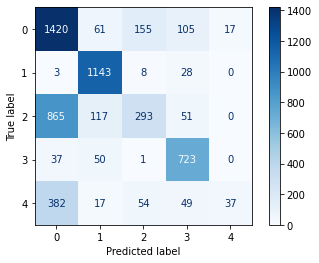

In [66]:
 # Train RFC model
n2v_rfc = RandomForestClassifier(random_state=SEED)
n2v_rfc.fit(X_train, y_train)

# make predictions on test set 
y_preds = n2v_rfc.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("Node2Vec + Random Forest Classifier Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(n2v_rfc, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')

> ### Logistic Regression CV

Node2Vec + LogRegCV Accuracy: 0.5796 



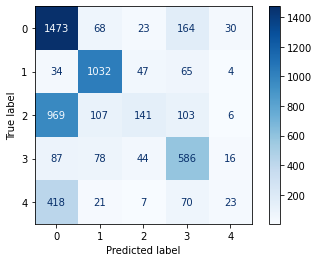

In [67]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
n2v_logreg = LogisticRegressionCV(cv=10, scoring="accuracy", random_state=SEED)

# classifier learns the training data
n2v_logreg.fit(X_train, y_train)

# make predictions on test set 
y_preds = n2v_logreg.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("Node2Vec + LogRegCV Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(n2v_logreg, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')

> ### K Nearest Neighbours

Node2Vec + K Nearest Neighbours Accuracy: 0.6172 



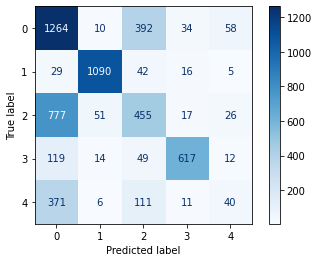

In [68]:
n2v_knc = KNeighborsClassifier()

n2v_knc.fit(X_train, y_train)

# make predictions on test set 
y_preds = n2v_knc.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("Node2Vec + K Nearest Neighbours Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(n2v_knc, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')

> ## DeepWalk

DeepWalk is an algorithm that is used to create embeddings of the nodes in a graph. The embeddings are meant to encode the community structure of the graph. It achieves this by using SkipGram to create the embeddings.

https://medium.com/@_init_/an-illustrated-explanation-of-using-skipgram-to-encode-the-structure-of-a-graph-deepwalk-6220e304d71b

In [ ]:
!pip install 'karateclub' # runtime needs to be restarted after installing to use new version of gensim

In [4]:
from karateclub import DeepWalk

In [10]:
# convert labels to integers to be compatible with deepwalk algorithm
intG = nx.relabel.convert_node_labels_to_integers(G)

In [11]:
# create and fit model on graph
dw_model = DeepWalk()
dw_model.fit(intG)
dw_embedding = dw_model.get_embedding()

In [12]:
# get nodes from graph
Gnodes = []
for i in G.nodes():
    Gnodes.append(i)
df_Gnodes = pd.DataFrame(Gnodes)

In [13]:
# get the label and embeddings for each labelled node
y = df['label']

X = []

# get embeddings for each node
for i in df['node_id'].values:
    idx = df_Gnodes.loc[df_Gnodes[0] == str(i)].index[0]
    X.append(dw_embedding[idx])

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df['label'], random_state=SEED)

> ### RFC

DeepWalk + Random Forest Classifier Accuracy: 0.8056 



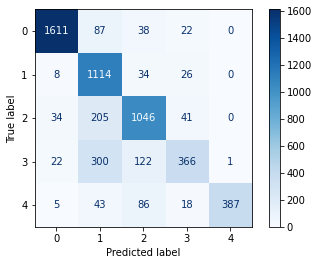

In [20]:
# Train RFC model
dw_rfc = RandomForestClassifier(random_state=SEED)
dw_rfc.fit(X_train, y_train)

# make predictions on test set 
y_preds = dw_rfc.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("DeepWalk + Random Forest Classifier Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(dw_rfc, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')

> ### Logistic Regression CV

DeepWalk + LogRegCV Accuracy: 0.7819 



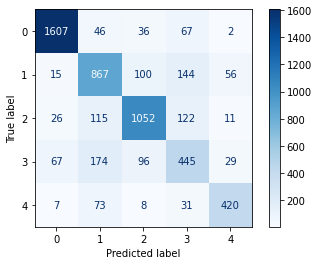

In [21]:
# Logistic Regression with Cross Validation
# function will automatically apply 10-fold cross validation to find the best hyperparameters
dw_logreg = LogisticRegressionCV(cv=10, scoring="accuracy", random_state=SEED)

# classifier learns the training data
dw_logreg.fit(X_train, y_train)

# make predictions on test set 
y_preds = dw_logreg.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("DeepWalk + LogRegCV Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(dw_logreg, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')

> ### K Nearest Neighbours

DeepWalk + K Nearest Neighbours Accuracy: 0.6797 



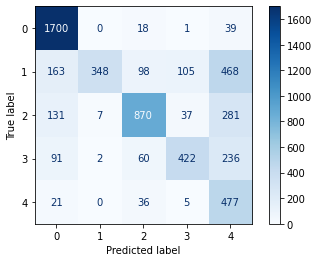

In [22]:
dw_knc = KNeighborsClassifier(n_neighbors=3)

dw_knc.fit(X_train, y_train)

# make predictions on test set 
y_preds = dw_knc.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_preds)

print("DeepWalk + K Nearest Neighbours Accuracy: {:.4}".format(acc), "\n")

plot_confusion_matrix(dw_knc, X_test, y_test, cmap=plt.cm.Blues, values_format = '.5g')